# Análisis de H1: Equipamiento inicial y supervivencia (SVR)

Este cuadernillo estudia la hipótesis:

**H1: A mayor valor de equipamiento inicial (`RoundStartingEquipmentValue`), mayor será el tiempo que un jugador sobrevive (`TimeAlive`).**

Se trabajará con un modelo de regresión (SVR) y una única variable predictora.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("csgo_ET2022.csv", sep=";")
df.head()

Saving csgo_ET2022.csv to csgo_ET2022.csv


<ipython-input-2-fe5c8ba0665b>:4: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("csgo_ET2022.csv", sep=";")


id         Map       Team  InternalTeamId  MatchId  RoundId RoundWinner  \
0  600  de_inferno  Terrorist               1        4        1       False   
1  601  de_inferno  Terrorist               1        4        1       False   
2  602  de_inferno  Terrorist               1        4        1       False   
3  603  de_inferno  Terrorist               1        4        1       False   
4  604  de_inferno  Terrorist               1        4        1       False   

  MatchWinner  Survived  AbnormalMatch  ... RoundKills RoundAssists  \
0        True     False          False  ...          0            0   
1        True     False          False  ...          0            0   
2        True     False          False  ...          0            0   
3        True     False          False  ...          0            0   
4        True      True          False  ...          0            0   

   RoundHeadshots  RoundFlankKills  RoundStartingEquipmentValue  \
0               0                0                          750   
1               0                0                          800   
2               0                0                         1000   
3               0                0                          850   
4               0                0                         1000   

   TeamStartingEquipmentValue  MatchKills  MatchFlankKills  MatchAssists  \
0                        4400           0                0             0   
1                        4400           0                0             0   
2                        4400           0                0             0   
3                        4400           0                0             0   
4                        4400           0                0             0   

  MatchHeadshots  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 30 columns]

# LIMPIEZA

In [ ]:
# Copiar dataset original
df_clean = df[df["AbnormalMatch"] == False].copy()  # Eliminar partidas con error de red

# Limpiar y convertir TimeAlive a segundos (dividir por 1e14)
# NOTA: una ronda normal en CS:GO dura en promedio entre 15 y 155 segundos
df_clean["TimeAlive"] = df_clean["TimeAlive"].str.replace(".", "", regex=False)
df_clean["TimeAlive"] = pd.to_numeric(df_clean["TimeAlive"], errors="coerce") / 1e14

# Filtrar valores de TimeAlive fuera del rango normal de una ronda
df_clean = df_clean[(df_clean["TimeAlive"] >= 15) & (df_clean["TimeAlive"] <= 155)]

# Limpiar y convertir TravelledDistance (remover puntos y convertir a metros)
# NOTA: un jugador en CS:GO puede recorrer de 10 a 150 metros aprox.
df_clean["TravelledDistance"] = df_clean["TravelledDistance"].astype(str).str.replace(",", ".", regex=False)
df_clean["TravelledDistance"] = df_clean["TravelledDistance"].str.replace(".", "", regex=False)
df_clean["TravelledDistance"] = pd.to_numeric(df_clean["TravelledDistance"], errors="coerce") / 1e15

# Eliminar outliers en RoundStartingEquipmentValue usando IQR
Q1 = df_clean["RoundStartingEquipmentValue"].quantile(0.25)
Q3 = df_clean["RoundStartingEquipmentValue"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df_clean[
    (df_clean["RoundStartingEquipmentValue"] >= lower_bound) &
    (df_clean["RoundStartingEquipmentValue"] <= upper_bound)
]

<ipython-input-3-b9c0527d274a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["TravelledDistance"] = df_clean["TravelledDistance"].astype(str).str.replace(",", ".", regex=False)
<ipython-input-3-b9c0527d274a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["TravelledDistance"] = df_clean["TravelledDistance"].str.replace(".", "", regex=False)
<ipython-input-3-b9c0527d274a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
print(df_clean[["TimeAlive", "TravelledDistance"]].describe()) # revisamos cómo afectó esta limpieza a las columnas 'TimeAlive' y 'TravelledDistance'.

          TimeAlive  TravelledDistance
count  56214.000000       56214.000000
mean      75.080981          11.881881
std       27.673434          12.302108
min       15.033467           0.000000
25%       52.192211           5.462743
50%       74.951775           9.088984
75%       95.410775          13.355638
max      154.548722          65.530265


In [ ]:
# Se analiza RoundWinner y MatchWinner en busca valores distintos y se pasan a booleano
print(df['RoundWinner'].unique())
print(df['MatchWinner'].unique())
nulos_matchwinner = df['MatchWinner'].isnull().sum()
print(f"Cantidad de valores NaN en MatchWinner: {nulos_matchwinner}")

['False' 'True' 'False4' True False]
[True False nan]
Cantidad de valores NaN en MatchWinner: 1


In [ ]:
# Encontrar la fila donde se encuentra el valor 'False4'
errores_roundwinner = df_clean[df_clean['RoundWinner'] == 'False4']

# Mostrar las columnas afectadas
print(errores_roundwinner[['id', 'Map', 'InternalTeamId', 'MatchId', 'RoundId', 'RoundWinner']])

     id         Map  InternalTeamId  MatchId  RoundId RoundWinner
29  629  de_inferno               2        4        3      False4


In [ ]:
# Buscar todos los jugadores de MatchId=4 y RoundId=3 y las columnas afectadas
ronda_especifica = df_clean[
    (df_clean['MatchId'] == 4) &
    (df_clean['RoundId'] == 3)
]
print(ronda_especifica[['id', 'InternalTeamId', 'RoundWinner']])

     id  InternalTeamId RoundWinner
21  621               1        True
22  622               1        True
24  624               1        True
25  625               2       False
26  626               2       False
27  627               2       False
28  628               2       False
29  629               2      False4


In [ ]:
# Se cambia dato de 'False4' por 'False' al jugador correspondiente.
df_clean.loc[
    (df_clean['id'] == 629) &
    (df_clean['MatchId'] == 4) &
    (df_clean['RoundId'] == 3),
    'RoundWinner'
] = False

# Mapear los valores para corregir 'True' y 'False' como booleanos reales
df_clean['RoundWinner'] = df_clean['RoundWinner'].map({
    'True': True,
    'False': False,
    True: True,
    False: False
})

# Volver a listar los valores únicos de RoundWinner
print(df_clean['RoundWinner'].unique())

[False  True]


In [ ]:
print(df_clean['MatchWinner'].unique())
print(df_clean['Team'].unique())

[True False nan]
['Terrorist' 'CounterTerrorist' nan]


In [ ]:
# Mostrar la fila que tiene MatchWinner nulo
fila_matchwinner_nulo = df_clean[df_clean['MatchWinner'].isnull()]
print(fila_matchwinner_nulo[['id', 'Map', 'InternalTeamId', 'MatchId', 'RoundId', 'MatchWinner']])

print(f"")
# Mostrar las filas que tiene Team nulo
fila_matchwinner_nulo = df_clean[df_clean['Team'].isnull()]
print(fila_matchwinner_nulo[['id', 'Map', 'Team', 'InternalTeamId', 'MatchId', 'RoundId', 'MatchWinner']])

     id         Map  InternalTeamId  MatchId  RoundId MatchWinner
29  629  de_inferno               2        4        3         NaN

     id         Map Team  InternalTeamId  MatchId  RoundId MatchWinner
13  613  de_inferno  NaN               1        4        2        True
27  627  de_inferno  NaN               2        4        3       False


In [ ]:
# Filtrar todas las filas del MatchId 4
partida = df_clean[df_clean['MatchId'] == 4]

# Analizar qué equipo ganó más rondas
rondas_ganadas = partida.groupby('Team')['RoundWinner'].sum()

print(rondas_ganadas)

Team
CounterTerrorist    21
Terrorist           63
Name: RoundWinner, dtype: int64


In [ ]:
# Dado que el jugador 629 tiene como 'Team' CounterTerrorist ahora podemos agregar el valor correspondiente en 'MatchWinner', es decir, False
df_clean.loc[
    (df_clean['id'] == 629),
    'MatchWinner'
] = False

In [ ]:
# Verificamos los nuevos valores
print(df_clean.loc[(df_clean['id'] == 629) & (df_clean['MatchId'] == 4), ['id', 'Map', 'InternalTeamId', 'MatchId', 'RoundId', 'RoundWinner', 'MatchWinner']])

     id         Map  InternalTeamId  MatchId  RoundId  RoundWinner MatchWinner
29  629  de_inferno               2        4        3        False       False


In [ ]:
# Mostrar las combinaciones únicas entre InternalTeamId y Team
combinaciones = df_clean[["MatchId", "InternalTeamId", "Team"]].drop_duplicates()
display(combinaciones.sort_values(["InternalTeamId", "Team"]))

# Contar cuántas veces cada InternalTeamId se asocia a cada Team
conteo = df_clean.groupby(["InternalTeamId", "Team"]).size().reset_index(name='Cantidad')
display(conteo.sort_values("InternalTeamId"))

# Verificar si dentro de una misma partida (MatchId) los equipos cambian su rol (T o CT)
cambio_en_partidas = df_clean.groupby(["MatchId", "InternalTeamId", "Team"]).size().reset_index(name='Recuento')
display(cambio_en_partidas.sort_values(["MatchId", "InternalTeamId"]))

# Identificar casos donde el mismo InternalTeamId se asocia a ambos bandos en distintas partidas
pivot = conteo.pivot(index="InternalTeamId", columns="Team", values="Cantidad")
display(pivot)

MatchId  InternalTeamId              Team
153          4               1  CounterTerrorist
343          6               1  CounterTerrorist
539          9               1  CounterTerrorist
783         10               1  CounterTerrorist
899         11               1  CounterTerrorist
...        ...             ...               ...
78032      505               2         Terrorist
78255      506               2         Terrorist
78692      509               2         Terrorist
78962      510               2         Terrorist
27           4               2               NaN

[1311 rows x 3 columns]

InternalTeamId              Team  Cantidad
0               1  CounterTerrorist     11015
1               1         Terrorist     17006
2               2  CounterTerrorist     17199
3               2         Terrorist     10992

MatchId  InternalTeamId              Team  Recuento
0           4               1  CounterTerrorist        32
1           4               1         Terrorist        52
2           4               2  CounterTerrorist        59
3           4               2         Terrorist        31
4           6               1  CounterTerrorist         4
...       ...             ...               ...       ...
1304      510               1         Terrorist        56
1305      510               2  CounterTerrorist        54
1306      510               2         Terrorist        47
1307      511               1         Terrorist        14
1308      511               2  CounterTerrorist        16

[1309 rows x 4 columns]

Team            CounterTerrorist  Terrorist
InternalTeamId                             
1                          11015      17006
2                          17199      10992

In [ ]:
# Filtramos los valores de matchid 510 donde internal team id 2 es terrorist y counterterrorist
filtered_df = df_clean[
    (df_clean['MatchId'] == 510) &
    (
        (df_clean['InternalTeamId'] == 2) &
        ((df_clean['Team'] == 'Terrorist') | (df_clean['Team'] == 'CounterTerrorist'))
    )
]

print(filtered_df[['MatchId', 'InternalTeamId', 'Team']])

       MatchId  InternalTeamId              Team
78812      510               2  CounterTerrorist
78814      510               2  CounterTerrorist
78815      510               2  CounterTerrorist
78816      510               2  CounterTerrorist
78822      510               2  CounterTerrorist
...        ...             ...               ...
79093      510               2         Terrorist
79094      510               2         Terrorist
79095      510               2         Terrorist
79096      510               2         Terrorist
79106      510               2         Terrorist

[101 rows x 3 columns]


In [ ]:
# Luego de todo el análisis podemos agregar los valores concordantes
df_clean.loc[
    (df_clean['id'] == 627),
    'Team'
] = 'CounterTerrorist'

df_clean.loc[
    (df_clean['id'] == 613),
    'Team'
] = 'Terrorist'

In [ ]:
# Verificar si hay valores nulos en las columnas 'Team' y 'MatchWinner' después de la limpieza
print("\nValores nulos después del tratamiento:")
print(df_clean[['Team', 'MatchWinner']].isnull().sum())


Valores nulos después del tratamiento:
Team           0
MatchWinner    0
dtype: int64


In [ ]:
# Calcular velocidad
df_clean["Speed_mps"] = df_clean["TravelledDistance"] / df_clean["TimeAlive"]

# Filtrar por velocidad entre 0.1 y 6 m/s (límite razonable)
df_clean = df_clean[
    (df_clean["Speed_mps"] >= 0.1) &
    (df_clean["Speed_mps"] <= 6)
].copy()
df_clean = df_clean[df_clean["Speed_mps"] >= 0.2]

In [ ]:
# Asegúrate de tener cargado el dataframe `df_clean` con limpieza aplicada
# Aquí solo se usará la variable de equipamiento individual
df_model_h1 = df_clean[['RoundStartingEquipmentValue', 'TimeAlive']].dropna()

In [ ]:
X = df_model_h1[['RoundStartingEquipmentValue']]
y = df_model_h1['TimeAlive']

# Escalar X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)

In [ ]:
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f} segundos")
print(f"R² Score: {r2:.4f}")

RMSE: 556.4640 segundos
R² Score: -0.0509


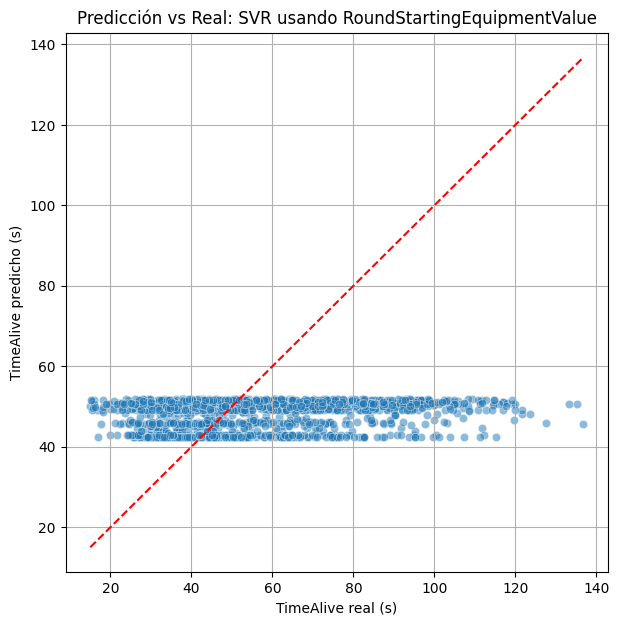

In [ ]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('TimeAlive real (s)')
plt.ylabel('TimeAlive predicho (s)')
plt.title('Predicción vs Real: SVR usando RoundStartingEquipmentValue')
plt.grid(True)
plt.show()